<h1 align="center"> Image Captioning </h1>

Итак, мы сейчас займемся image captioning =)
![img](https://i.imgur.com/obITaMl.png)

## Описание

Image captioning -- это когда мы подаем модели каритнку, а она возвращает нам текст с описанием того, что на ней изображено. 

Как мы знаем из нашего замечательного курса, с картинками лучше всегоработают модели CNN, а с текстом -- RNN. Поэтому логично, что для image captioning нужно совместить и то, и другое =)

Для удобства (и, в какой-то степени, экономии времени), мы будем строить не одну большую модель CNN+RNN, которая будет кушать картинку и выдавать текст, а разобьем ее на две. Первая модель будет кушать картинку и выдавать вектор картинки, а вторая модель будет кушать этот вектор и генерировать текст. Вектор, по сути, будет числовым "описанием" картинки, в котором будет содержаться вся необходимая информация для второй сети, чтобы та смогла нагенерить текста с описанием. Короче, как в автоэнкодерах)

## План

Итак, как мы будем действовать:

Датасет: MSCOCO: [описание](http://cocodataset.org/#download), [ссылка для скачивания](https://yadi.sk/d/iK9ZtggjJcGKIA)

### Базовая часть:
1. Скачаем датасет (векторы картинок и соответствующие описания) и предобработаем описания так, как мы любим. Ну, токенизация там (да, в 100500-ый раз, только теперь сами)
2. В качестве первой сети возьмем Inception-v3 и скачаем к ней предобученные веса (тренировать и генерировать веса -- это оч долго, поверьте мне). 
3. Напишем вторую сетку, которая будет брать векторы из Inception-v3 и генерить описания.
4. Обучим вторую сеть на MSCOCO

### Вариативная часть:
Что еще можно сделать:
1. Нагуглить другой датасет (в MSCOCO видны паттерны -- все тексты выглядят как "хто-то с чем-то что-то делает")
2. Взять не Inseption-v3, а другую предобученную сеть
3. Запилить аттеншен во второй сети (не, ну а вдруг)
4. Написать бота ))0))
5. Whatever comes to your head

## Базовая часть:

### 1. Предобработка текстов из датасета

In [1]:
!pip install scipy==1.1.0

In [2]:
DATA_PATH = ''
%matplotlib inline

# For Google Colab only:
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')
#from reco_utils.recommender.sar.sar_singlenode import SARSingleNode
from google.colab import drive
drive.mount('/content/gdrive')

DATA_PATH = 'gdrive/My Drive/Colab Notebooks/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import numpy as np
import json

# загружаем датасет
img_codes = np.load("/content/gdrive/MyDrive/MSCOCO/image_codes.npy")
captions = json.load(open('/content/gdrive/MyDrive/MSCOCO/captions_tokenized.json'))

In [4]:
img_codes.shape

(118287, 2048)

In [4]:
# посмотрим на датасет
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


Как можно видеть, в датасете все captions (тексты-описания) уже токенизированы и приведены в нижний регистр. Нам осталось сделать следующее:

1. Добавить ко всем описаниям символы начала и конца предложения 
2. Посчитать частоту встречания каждого слова из словаря и оставить тольео те, которые встречаются больше Х раз (например, Х=5)
3. Создать словарь из оставшихся слов + символов начала, конца предложения и PAD символа
4. Написать функцию, которая будет возвращать батч из описаний. Мы такое уже делали на прошлвх занятиях. Батч должен выглядеть примерно так:
ВАЖНО! Почему я советую писать отдельную функцию, которая генерирует батч: дело в том, что в датасете для каждой картинки есть несколько (5-7) различных описаний. Когда создаете батч, лучше, чтобы в нем были разные картинки, и к каждой картинке при создании батча выбирать одно из ее описаний рандомно. Это проще реализовать в отдельной функции (но вы, конечно, можете писать код как хотите)
5. Поделить выборку на train/test

[[   1,  525, 8955, 5392, 9640, 4713, 7470,  525, 7341, 2296, 7696,2,    3,    3,    3,    3,    3,    3,    3],
   
[   1,  525, 8955, 6784, 3557,  525, 7341, 2296,    2,    3,    3,3,    3,    3,    3,    3,    3,    3,    3],

[   1,  525, 8955, 9209, 3557, 5486, 8335, 3071, 2296,    2,    3,3,    3,    3,    3,    3,    3,    3,    3],

[   1, 6292, 1508, 8955, 9209, 6784, 3557, 3071, 6971, 5520, 7696,2,    3,    3,    3,    3,    3,    3,    3],

[   1,  525, 8955, 6784, 3557,  525, 7341, 6919, 2919, 6292,  250,393,  525, 4618, 8335, 6292, 7882, 7696,    2]]
         
То есть, короткие предложения дополняются PAD символами, слишком длинные обрезуются, в начале и конце по коду символа начал и конца предложения.

Уверена, эта часть вам покажется очень знакомой и легкой =)

In [5]:
my_dict = {}
for i in range(len(captions)):
    for j in range(len(captions[i])):
        s = captions[i][j].split(' ')
        for ss in range(len(s)):
            if my_dict.get(s[ss]) == None:
                my_dict[s[ss]] = 1
            else:
                my_dict[s[ss]] += 1

In [6]:
dict_nums = {}
word_dict = {}
count = 4

for i in my_dict.keys():
    if my_dict[i] > 5:
        dict_nums[i] = count
        word_dict[count] = i
        count += 1

In [7]:
import random

def get_padded(values):
    max_len = 0
    for value in values:
        if len(value) > max_len:
            max_len = len(value)

    padded = np.array([value + [3]*(max_len-len(value)) for value in values])

    return padded

def collate_fn(batch):

    images = []
    annots = []
    for elem in batch:
        #print('elem0', elem[0])
        #print('elem1', elem[1])
        images.append(elem[0].numpy())
        idx = elem[1]
        capts = captions[idx]
        rn = random.randrange(0, len(capts) - 1, 1)
        capt = capts[rn]
        capt_s = capt.split(' ')
        emb = []
        emb.append(1)
        for x in range(len(capt_s)):
          if dict_nums.get(capt_s[x]) != None:
            emb.append(dict_nums[capt_s[x]])
        emb.append(2)
        annots.append(emb)

    capts = get_padded(annots) # padded inputs
    # attention_mask = np.where(inputs != 0, 1, 0)

    #print('images', images)

    return {"image": torch.tensor(images), "caption": torch.tensor(capts, dtype=torch.long)}

In [22]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import Dataset, random_split
import torch.utils.data as data_utils

batch_size = 256

data_idx = [x for x in range(118287)]

inputs  = torch.tensor(img_codes)
targets = torch.IntTensor(data_idx)
    
dataset = TensorDataset(inputs, targets)

train_size, val_size = int(.8 * len(dataset)), int(.1 * len(dataset))
torch.manual_seed(2) 
train_data, valid_data, test_data = random_split(dataset, [train_size, val_size, len(dataset) - train_size - val_size])

train_loader = DataLoader(train_data, batch_size, shuffle = True, collate_fn=collate_fn)
val_loader = DataLoader(valid_data, batch_size, shuffle = True, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size, shuffle = True, collate_fn=collate_fn)

In [10]:
for batch in train_loader:
    a = batch["image"]
    b = batch["caption"]
    print(a.shape)
    print(b.shape)
    break

torch.Size([512, 2048])
torch.Size([512, 33])


### 2. Напишем свою сетку из RNN для вывода описаний


Сейчас мы напишем сеть, которая будет получать выходы CNN-сетки (эмбеддинги картинок) и преобразовывать их в текст.

In [10]:
import torch, torch.nn as nn
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [32]:
class CaptionNet(nn.Module):
    def __init__(self, cnn_feature_size=2048, input_dim = 2048, dict_size = 1, emb_dim=300, hid_dim=300, n_layers=2, dropout=0.6, bidirectional=False):
        super(self.__class__, self).__init__()


        # стандартная архитектура такой сети такая: 
        # 1. линейные слои для преобразования эмбеддиинга картинки в начальные состояния h0 и c0 LSTM-ки
        # 2. слой эмбедднга
        # 3. несколько LSTM слоев (для начала не берите больше двух, чтобы долго не ждать)
        # 4. линейный слой для получения логитов
        
        self.cnn_feature_size = cnn_feature_size
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.bidirectional = bidirectional
        self.output_dim = dict_size
        
        self.dropout = nn.Dropout(dropout)
        self.embedding = nn.Embedding(dict_size, emb_dim, padding_idx=3)
        self.fc1 = nn.Linear(cnn_feature_size, hid_dim)
        self.fc2 = nn.Linear(cnn_feature_size, hid_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, num_layers=n_layers, dropout=dropout, bidirectional=bidirectional)
        self.fc3 = nn.Linear(emb_dim, dict_size)
        
    def forward(self, image_vectors, captions_ix, teacher_forcing_ratio):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor, содержащий выходы inseption. Те, из которых будем генерить текст
                shape: [batch, cnn_feature_size]
        :param captions_ix: 
                таргет описания картинок в виде матрицы
        :returns: логиты для сгенерированного текста описания, shape: [batch, word_i, n_tokens]

        Обратите внимание, что мы подаем сети на вход сразу все префиксы описания 
        и просим ее к каждому префиксу сгенерировать следующее слово!
        """
        
        # 1. инициализируем LSTM state
        # 2. применим слой эмбеддингов к image_vectors
        # 3. скормим LSTM captions_emb
        # 4. посчитаем логиты из выхода LSTM

        h0 = self.fc1(image_vectors)
        c0 = self.fc2(image_vectors)
        hidden = torch.stack((h0, h0), 0)
        cell = torch.stack((c0, c0), 0)

        batch_size = captions_ix.shape[0]
        trg_len = captions_ix.shape[1]

        #print("batch_size: ", batch_size)
        #print("trg_len: ", trg_len)

        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, self.output_dim).to(device)

        #first input to the decoder is the <sos> tokens
        input = captions_ix[:,0]
        #print("input: ", input)

        for t in range(1, trg_len): # 1, 
            embedding = self.embedding(input)
            #print("embedding.shape: ", embedding.shape)
            embedding = self.dropout(embedding.reshape(1, batch_size, self.emb_dim))
            # print("input.shape: ", input.shape)
            # print("input: ", input)
            output, (hidden, cell) = self.rnn(embedding, (hidden, cell))
            # print("output.shape: ", output.shape)
            # print("hidden.shape: ", hidden.shape)
            outputs[t] = self.fc3(output)
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            #get the highest predicted token from our predictions
            top1 = outputs[t].argmax(-1)  #output.argmax(-1) 
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            #print(teacher_force)
            input = captions_ix[:, t] if teacher_force else top1

        logits = outputs 
        
        return logits   

    def get_init_hid_cel(self, image_vectors):
        h0 = self.fc1(image_vectors)
        c0 = self.fc2(image_vectors)
        h0 = torch.stack((h0, h0), 0)
        c0 = torch.stack((c0, c0), 0)
        return h0, c0

    def get_logit(self, word_id, hidden, cell):     
      embedding = self.embedding(word_id)
      embedding = embedding.reshape(1, 1, self.emb_dim)
      output, (hidden, cell) = self.rnn(embedding, (hidden, cell))
      output = self.fc3(output)
      return output, hidden, cell

In [ ]:
network = CaptionNet(dict_size = count).to(device)

In [20]:
def compute_loss(network, image_vectors, captions_ix, teacher_forcing):
    """
    :param image_vectors: torch tensor c выходами inception. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor с описаниями (в виде матрицы). shape: [batch, word_i]. 
    
    :returns: scalar crossentropy loss (neg log likelihood) for next captions_ix given previous ones
    """
    
    # реализуйте стандартный cross entropy loss: итоговый лосс есть сумма лоссов для каждого слова. 
    # 1. Получаем логиты, прогоняя image_vectors через сеть
    # 2. Вычисляем лосс-функцию между полученными логитами и captions_ix. Будьте внимательны: 
    # вычисляйте лосс между логитами, полученными из сети, и соответствующими им значениями из captions_ix!
    
    # ВАЖНО: не забудтье, что PADDING не должен влиять на лосс -- лосс должен склыдваться
    # только из тех мест, где должно быть предсказано слово, а не PAD
    # это можно сделать либо заведя маску из нулей и единиц (captions_ix_next != pad_ix) и умножить на нее лосс,
    # либо просто используя ignore_index, который в торче есть как аргумент у некоторых лоссов.
    
    output = network(image_vectors, captions_ix,  teacher_forcing)

    #print("output1.shape", output.shape)
    #print("captions_ix1.shape", captions_ix.shape)
    output = output.transpose(1, 0) # [batch_size, seq_len, dict_size]
    #print("output.transpose.shape", output.shape)
    output = output[:,1:,:] #.view(-1, count)
    output = output.reshape(-1, count)
    #print("output1.shape", output.shape)
    trg = captions_ix[:,1:] #.view(-1) 
    trg = trg.reshape(-1)
    #print("output.view.shape", output)
    #print("trg.shape", trg.shape)

    # print("output.shape", output.shape)
    # print("trg.shape", trg.shape)

    loss = criterion(output, trg)
    
    return loss

In [ ]:
import torch.optim as optim
optimizer = optim.Adam(network.parameters()) # favourite one

## Train it

Как обычно, пишем цикл тренировки, запоминаем лоссы для графиков и раз в Х такстов тренировки считаем val_loss. 

In [12]:
PAD_IDX = 3 #TRG.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch['image'].to(device)
        trg = batch["caption"].to(device)

        # print("src.shape: ", src.shape)
        # print("src: ", src)

        optimizer.zero_grad()
        
        # output = model(src, trg)
        
        # #trg = [trg sent len, batch size]
        # #output = [trg sent len, batch size, output dim]
        
        # output = output[1:].view(-1, OUTPUT_DIM)
        # trg = trg[1:].view(-1)
        
        # #trg = [(trg sent len - 1) * batch size]
        # #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = compute_loss(model, src, trg, 0.5)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch['image'].to(device)
            trg = batch["caption"].to(device)

            #vectors_8x8, vectors_neck, logits = inception(src)
            
             #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            loss = compute_loss(model, src, trg, 0)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [11]:
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
import time
import math

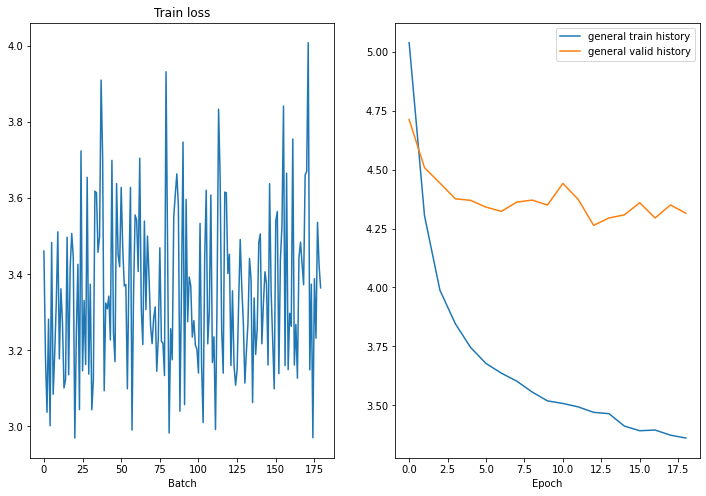

Epoch: 20 | Time: 3m 45s
	Train Loss: 3.351 | Train PPL:  28.523
	 Val. Loss: 4.283 |  Val. PPL:  72.434


In [ ]:
train_history = []
valid_history = []

N_EPOCHS = 20
CLIP = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(network, train_loader, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(network, val_loader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(network.state_dict(), 'best-val-network.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
torch.save(network.state_dict(), 'best-state-network.pt')
torch.save(network, 'best-network.pt')

## Inseption и получение результатов


In [13]:
# загружаем inseption, чтобы можно было прогонять через него новые картинки, 
# получать их эмбеддинги и генерировать описания с помощью нашей сети
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

/usr/local/lib/python3.7/dist-packages/torchvision/models/inception.py:82: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)


### Сгенерируем описание

In [13]:
def generate_caption(image, caption_prefix=1, 
                     t=1, sample=True, max_len=100):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    network.eval()
    with torch.no_grad():
        # print('image.shape', image.shape)
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)
        # print('image.shape', image.shape)

        vectors_8x8, vectors_neck, logits = inception(image[None])

        # print('vectors_8x8 shape', vectors_8x8.shape)
        # print('vectors_neck shape', vectors_neck.shape)
        # print('logits shape', logits.shape)


        caption_prefix = torch.tensor(caption_prefix) #list(caption_prefix) 
        caption_prefix = caption_prefix.reshape(1, 1)
        #print("caption_prefix", caption_prefix)
        caption = []
        # слово за словом генерируем описание картинки
        #for _ in range(max_len):
            # 1. представляем caption_prefix в виде матрицы
            # 2. Получить из RNN-ки логиты, передав ей vectors_neck и матрицу из п.1
            # 3. Перевести логиты RNN-ки в вероятности (например, с помощью F.softmax)
            # 4. сэмплировать следующее слово в описании, используя полученные вероятности. Можно сэмплировать жадно 
            # (тупо слово с самой большой вероятностью), можно сэмплировать из распределения
            # 5. Добавляем новое слово в caption_prefix
            # 6. Если RNN-ка сгенерила символ конца предложения, останавливаемся

        word_id = caption_prefix
        hidden, cell = network.get_init_hid_cel(vectors_neck.to(device))
        for word in range(max_len):
          logit, hidden, cell = network.get_logit(word_id.to(device), hidden.to(device), cell.to(device))
          #print(logit)
          logit = F.softmax(logit, dim=2)
          #print(logit.shape)
          word_id = torch.argmax(logit)
          word_id = word_id.cpu().numpy().item() #np.asscalar
          #print(word_id)
          if word_id == 2:
              break

          caption.append(word_dict[word_id])
          caption_prefix = [word_dict[word_id]]
          word_id = torch.tensor(word_id)

    return caption

### Скачаем пару картинок, чтобы проверить качество:

In [ ]:
from matplotlib import pyplot as plt
from skimage.transform import resize
from scipy.misc import imresize
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img.jpg
img = plt.imread('img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.
#img = resize(img, (299, 299)).astype('float32') / 255.

#generate_caption(img, caption_prefix=1, t=5.)

--2021-07-07 11:16:30--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 199.232.192.70, 199.232.196.70
Connecting to pixel.nymag.com (pixel.nymag.com)|199.232.192.70|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg [following]
--2021-07-07 11:16:31--  https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg
Resolving pyxis.nymag.com (pyxis.nymag.com)... 151.101.2.217, 151.101.66.217, 151.101.130.217, ...
Connecting to pyxis.nymag.com (pyxis.nymag.com)|151.101.2.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54731 (53K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  53.45K  --.-KB/s    in 0.01s   

2021-07-07 11:16:31 (4.17 MB/s) - ‘img.jpg’ saved [54731

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  if __name__ == '__main__':


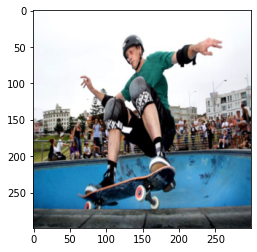

In [ ]:
plt.imshow(img)

In [ ]:
#generate_caption(img, caption_prefix=1, t=5.)
print(' '.join(generate_caption(img)[1:-1]))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


man doing a trick on a skateboard


--2021-07-07 11:17:22--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 104.239.249.248
Connecting to ccanimalclinic.com (ccanimalclinic.com)|104.239.249.248|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg [following]
--2021-07-07 11:17:22--  https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Connecting to ccanimalclinic.com (ccanimalclinic.com)|104.239.249.248|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 104.37K   196KB/s    in 0.5s    

2021-07-07 11:17:24 (196 KB/s) - ‘img.jpg’ saved [106870/106870]



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


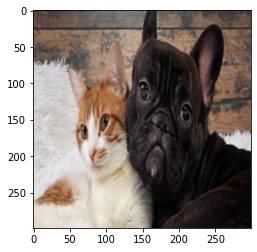

In [ ]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O img.jpg
img = plt.imread('img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

In [ ]:
print(' '.join(generate_caption(img, t=5.)[1:-1]))

cat is laying on a of a a


# Bleu

In [33]:
network1 = CaptionNet(dict_size = count).to(device)
network1 = torch.load('best-network (1).pt')

In [37]:
from nltk.translate.bleu_score import corpus_bleu

def generate_caption_by_codes(image_codes, caption_prefix=1, 
                     t=1, sample=True, max_len=100):
    network1.eval()
    with torch.no_grad():

        caption_prefix = torch.tensor(caption_prefix) #list(caption_prefix) 
        caption_prefix = caption_prefix.reshape(1, 1)
        caption = []

        word_id = caption_prefix
        hidden, cell = network1.get_init_hid_cel(image_codes.to(device))
        for word in range(max_len):
            logit, hidden, cell = network1.get_logit(word_id.to(device), hidden.to(device), cell.to(device))
           #print(logit)
            logit = F.softmax(logit, dim=2)
            #print(logit.shape)
            word_id = torch.argmax(logit)
            word_id = word_id.cpu().numpy().item() #np.asscalar
            #print(word_id)
            if word_id == 2:
               break

            caption.append(word_dict[word_id])
            caption_prefix = [word_dict[word_id]]
            word_id = torch.tensor(word_id)

    return caption


def get_generated_text(image_codes, caption_prefix = 1, max_len = 100):
        generated = []
        for batch in range(image_codes.shape[0]):
            caption = generate_caption_by_codes(image_codes[batch, :].reshape(1, 2048))
            txt = ' '.join(caption)
            generated.append(txt)
        return generated

def get_taget_text(caption):
        target_text = []
        for batch in range(caption.shape[0]):
            text = []
            for w in range(1, caption.shape[1]):
                word_id = caption[batch][w]
                word_id = word_id.cpu().numpy().item()
                if word_id == 2:
                    break
                text.append(word_dict[word_id])
            txt = ' '.join(text)
            target_text.append(txt)
        return target_text

In [38]:
import tqdm
original_text = []
generated_text = []
network.eval()
with torch.no_grad():
    for i, batch in tqdm.tqdm(enumerate(test_loader)):

        src = batch['image'].to(device)
        trg = batch["caption"].to(device)
        
        original_text.append(get_taget_text(trg))
        texts = get_generated_text(src)
        generated_text.append(texts)

47it [01:02,  1.33s/it]


In [39]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


9.588569354001242

# Demo

ВОТ ЩАС БУИТ СМИШНО

Теперь ищите свои картинки, применяйте к ним сетку, смотрите че получится, реализовывайте вариативную часть =)

--2021-07-07 11:18:32--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 104.239.249.248
Connecting to ccanimalclinic.com (ccanimalclinic.com)|104.239.249.248|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg [following]
--2021-07-07 11:18:32--  https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Connecting to ccanimalclinic.com (ccanimalclinic.com)|104.239.249.248|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 104.37K   196KB/s    in 0.5s    

2021-07-07 11:18:34 (196 KB/s) - ‘img.jpg’ saved [106870/106870]



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


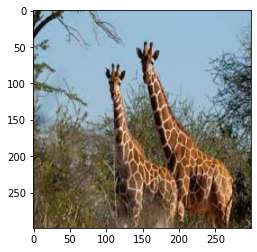

giraffe standing in a field with trees


In [ ]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O img.jpg
img = plt.imread('jur.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

print(' '.join(generate_caption(img, t=5.)[1:-1]))

## Бонус: Achtung

В качестве бонусного задания предлагается реализовать механизм attention в rnn-сети, которую мы писали в базовой части.

In [14]:
class Attention(nn.Module):
  def __init__(self, num_features, hidden_dim = 300, output_dim = 1, n_layers = 2):
    super(self.__class__, self).__init__()
    self.num_features = num_features
    self.hidden_dim = hidden_dim
    self.output_dim = output_dim
    self.n_layers = n_layers
    # fully-connected layer to learn first weight matrix Wa
    self.W_a = nn.Linear(self.num_features, self.hidden_dim)
    # fully-connected layer to learn the second weight matrix Ua
    self.U_a = nn.Linear(self.n_layers * self.hidden_dim, self.hidden_dim)
    # fully-connected layer to produce score (output), learning weight matrix va
    self.v_a = nn.Linear(self.hidden_dim, self.output_dim)

  def forward(self, features, hidden):
   ##print("features.shape", features.shape)
    #print("hidden.shape", hidden.shape)
    hidden = hidden.reshape(hidden.shape[1], self.n_layers * hidden.shape[2]) #hidden.unsqueeze(1)
    #print("hidden.shape", hidden.shape)
    atten_1 = self.W_a(features)
    #print("atten_1.shape", atten_1.shape)
    atten_2 = self.U_a(hidden)
    #print("atten_2.shape", atten_2.shape)
    # apply tangent to combine result from 2 fc layers
    atten_tan = torch.tanh(atten_1 + atten_2)
    #print("atten_tan.shape", atten_tan.shape)
    atten_score = self.v_a(atten_tan)
    #print("atten_score.shape", atten_score.shape)
    atten_weight = F.softmax(atten_score, dim = 1)
    #print("atten_weight.shape", atten_weight.shape)
    # first, we will multiply each vector by its softmax score
    # next, we will sum up this vectors, producing the attention context vector
    # the size of context equals to a number of feature maps
    context = atten_weight * features
    #print("context.shape", context.shape)
    atten_weight = atten_weight.squeeze(dim=1)
    #print("atten_weight.shape", atten_weight.shape)
        
    return context, atten_weight

In [15]:
class CaptionNetWithAttention(nn.Module):
    def __init__(self, cnn_feature_size=2048, input_dim = 2048, dict_size = 1, emb_dim=300, hid_dim=300, n_layers=2, dropout=0.6, bidirectional=False):
        super(self.__class__, self).__init__()


        # стандартная архитектура такой сети такая: 
        # 1. линейные слои для преобразования эмбеддиинга картинки в начальные состояния h0 и c0 LSTM-ки
        # 2. слой эмбедднга
        # 3. несколько LSTM слоев (для начала не берите больше двух, чтобы долго не ждать)
        # 4. линейный слой для получения логитов
        
        self.cnn_feature_size = cnn_feature_size
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.bidirectional = bidirectional
        self.output_dim = dict_size
        
        self.dropout = nn.Dropout(dropout)
        self.embedding = nn.Embedding(dict_size, emb_dim, padding_idx=3)
        self.fc1 = nn.Linear(cnn_feature_size, hid_dim)
        self.fc2 = nn.Linear(cnn_feature_size, hid_dim)
        self.rnn = nn.LSTM(emb_dim + cnn_feature_size, hid_dim, num_layers=n_layers, dropout=dropout, bidirectional=bidirectional)
        self.fc3 = nn.Linear(emb_dim, dict_size)
        self.attention = Attention(cnn_feature_size, hid_dim)
        
    def forward(self, image_vectors, captions_ix, teacher_forcing_ratio):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor, содержащий выходы inseption. Те, из которых будем генерить текст
                shape: [batch, cnn_feature_size]
        :param captions_ix: 
                таргет описания картинок в виде матрицы
        :returns: логиты для сгенерированного текста описания, shape: [batch, word_i, n_tokens]

        Обратите внимание, что мы подаем сети на вход сразу все префиксы описания 
        и просим ее к каждому префиксу сгенерировать следующее слово!
        """
        
        # 1. инициализируем LSTM state
        # 2. применим слой эмбеддингов к image_vectors
        # 3. скормим LSTM captions_emb
        # 4. посчитаем логиты из выхода LSTM

        h0 = self.fc1(image_vectors)
        c0 = self.fc2(image_vectors)
        hidden = torch.stack((h0, h0), 0)
        cell = torch.stack((c0, c0), 0)

        batch_size = captions_ix.shape[0]
        trg_len = captions_ix.shape[1]

        #print("batch_size: ", batch_size)
        #print("trg_len: ", trg_len)

        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, self.output_dim).to(device)

        #first input to the decoder is the <sos> tokens
        input = captions_ix[:,0]
        #print("input: ", input)

        for t in range(1, trg_len): # 1, 
            embedding = self.dropout(self.embedding(input))
            #print("embedding.shape: ", embedding.shape)
            # print("input.shape: ", input.shape)
            # print("input: ", input)

            context, atten_weight = self.attention(image_vectors, hidden)
            #print("context.shape: ", context.shape)
            #print("embedding.shape: ", embedding.shape)
            embedding = torch.cat((context, embedding), 1)
            #print("embedding.shape: ", embedding.shape)
            embedding = embedding.reshape(1, batch_size, embedding.shape[1])
            output, (hidden, cell) = self.rnn(embedding, (hidden, cell))

            # print("output.shape: ", output.shape)
            # print("hidden.shape: ", hidden.shape)
            outputs[t] = self.fc3(output)
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            #get the highest predicted token from our predictions
            top1 = outputs[t].argmax(-1)  #output.argmax(-1) 
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            #print(teacher_force)
            input = captions_ix[:, t] if teacher_force else top1

        logits = outputs 
        
        return logits   

    def get_init_hid_cel(self, image_vectors):
        h0 = self.fc1(image_vectors)
        c0 = self.fc2(image_vectors)
        h0 = torch.stack((h0, h0), 0)
        c0 = torch.stack((c0, c0), 0)
        return h0, c0

    def get_logit(self, word_id, hidden, cell):     
      embedding = self.embedding(word_id)
      embedding = embedding.reshape(1, 1, self.emb_dim)
      output, (hidden, cell) = self.rnn(embedding, (hidden, cell))
      output = self.fc3(output)
      return output, hidden, cell

In [16]:
network = CaptionNetWithAttention(dict_size = count).to(device)

In [17]:
import torch.optim as optim
optimizer = optim.Adam(network.parameters()) # favourite one

In [18]:
PAD_IDX = 3 #TRG.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch['image'].to(device)
        trg = batch["caption"].to(device)

        # print("src.shape: ", src.shape)
        # print("src: ", src)

        optimizer.zero_grad()
        
        # output = model(src, trg)
        
        # #trg = [trg sent len, batch size]
        # #output = [trg sent len, batch size, output dim]
        
        # output = output[1:].view(-1, OUTPUT_DIM)
        # trg = trg[1:].view(-1)
        
        # #trg = [(trg sent len - 1) * batch size]
        # #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = compute_loss(model, src, trg, 0.5)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch['image'].to(device)
            trg = batch["caption"].to(device)

            #vectors_8x8, vectors_neck, logits = inception(src)
            
             #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            loss = compute_loss(model, src, trg, 0)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

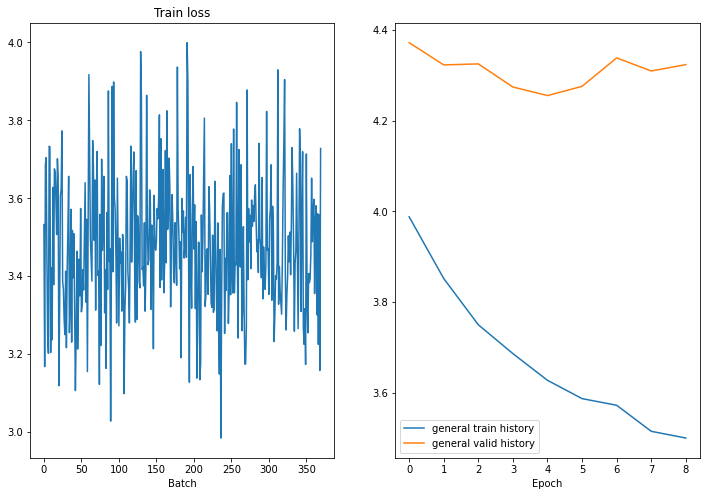

Epoch: 10 | Time: 2m 46s
	Train Loss: 3.475 | Train PPL:  32.303
	 Val. Loss: 4.293 |  Val. PPL:  73.186


In [23]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(network, train_loader, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(network, val_loader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(network.state_dict(), 'best-val-network.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [27]:
from nltk.translate.bleu_score import corpus_bleu

def generate_caption_by_codes(image_codes, caption_prefix=1, 
                     t=1, sample=True, max_len=100):
    network.eval()
    with torch.no_grad():

        caption_prefix = torch.tensor(caption_prefix) #list(caption_prefix) 
        caption_prefix = caption_prefix.reshape(1, 1)
        caption = []

        word_id = caption_prefix
        hidden, cell = network.get_init_hid_cel(image_codes.to(device))
        for word in range(max_len):
            logit, hidden, cell = network.get_logit(word_id.to(device), hidden.to(device), cell.to(device))
           #print(logit)
            logit = F.softmax(logit, dim=2)
            #print(logit.shape)
            word_id = torch.argmax(logit)
            word_id = word_id.cpu().numpy().item() #np.asscalar
            #print(word_id)
            if word_id == 2:
               break

            caption.append(word_dict[word_id])
            caption_prefix = [word_dict[word_id]]
            word_id = torch.tensor(word_id)

    return caption


def get_generated_text(image_codes, caption_prefix = 1, max_len = 100):
    generated = []
    for batch in range(image_codes.shape[0]):
        caption = generate_caption_by_codes(image_codes[batch, :].reshape(1, 2048))
        txt = ' '.join(caption)
        generated.append(txt)
    return generated

def get_taget_text(caption):
    target_text = []
    for batch in range(caption.shape[0]):
        text = []
        for w in range(1, caption.shape[1]):
            word_id = caption[batch][w]
            word_id = word_id.cpu().numpy().item()
            if word_id == 2:
                break
            text.append(word_dict[word_id])
        txt = ' '.join(text)
        target_text.append(txt)
    return target_text

In [28]:
import tqdm
original_text = []
generated_text = []
network.eval()
with torch.no_grad():
    for i, batch in tqdm.tqdm(enumerate(test_loader)):

        src = batch['image'].to(device)
        trg = batch["caption"].to(device)
        
        original_text.append(get_taget_text(trg))
        texts = get_generated_text(src)
        generated_text.append(texts)

0it [00:00, ?it/s]


RuntimeError: ignored

In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100